# **Attentive Statistics Pooling for Deep Speaker Embedding**

Okabe, K., Koshinaka, T., & Shinoda, K. (2018). Attentive statistics pooling for deep speaker embedding. arXiv preprint arXiv:1803.10963.

## **Default Setting**

In [1]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 686kB 6.6MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import os

import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

print("[VERSION]")
print(f"tensorflow       : {tf.__version__}")
print(f"tensorflow addons: {tfa.__version__}")

[VERSION]
tensorflow       : 2.5.0
tensorflow addons: 0.13.0


In [3]:
!nvidia-smi; free -h

Mon Jul 12 07:56:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
## Define mixed precision policy.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P4, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [5]:
class HParams(object):
    def __init__(self):
        self.mapping_dict = None

        ## Dataset.
        self.n_cpus = len(tf.config.list_physical_devices("CPU"))
        self.n_gpus = len(tf.config.list_physical_devices("GPU")) ## torch.cuda.device_count()

        self.per_replica_batch_size = 48
        self.global_batch_size = self.per_replica_batch_size * (self.n_gpus if self.n_gpus else self.n_cpus)

        self.auto = tf.data.AUTOTUNE

        self.slice_length = 16_000

        ## Mel-Spectrogram.
        self.sample_rate    = 8_000
        self.sample_rate_ms = 8
        self.frame_length   = 25 * self.sample_rate_ms
        self.frame_step     = 10 * self.sample_rate_ms
        self.fft_length     = 512
        self.window_fn      = tf.signal.hamming_window
        self.pad_end        = True
        
        self.num_mel_bins = 64
        self.num_spectrogram_bins = self.fft_length // 2 + 1
        self.lower_edge_hertz = 0.
        self.upper_edge_hertz = 4_000.

        ## Modeling.
        self.num_classes = 8

        ## Training.
        self.learning_rate = 3e-4
        self.epochs = 10


HPARAMS = HParams()

## **Dataset**

### **Load Dataset**

In [6]:
data_dir = Path("data/mini_speech_commands")
if not data_dir.exists():
    tf.keras.utils.get_file(
        "mini_speech_commands.zip",
        origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract = True,
        cache_dir = ".", 
        cache_subdir = "data")

182083584/182082353 [==============================] - 1s 0us/step


In [7]:
tmp = np.array(sorted(list(data_dir.glob("down/*.wav"))))
tmp[:5]

array([PosixPath('data/mini_speech_commands/down/004ae714_nohash_0.wav'),
       PosixPath('data/mini_speech_commands/down/00b01445_nohash_1.wav'),
       PosixPath('data/mini_speech_commands/down/00f0204f_nohash_0.wav'),
       PosixPath('data/mini_speech_commands/down/0132a06d_nohash_1.wav'),
       PosixPath('data/mini_speech_commands/down/0132a06d_nohash_4.wav')],
      dtype=object)

### **Build Dataset Pipelines**

In [8]:
commands = [i.parts[-2] for i in list(data_dir.glob("*/*.wav"))]
commands = np.array(sorted(list(set(commands))))
mapping_dict = {j:i for i, j in enumerate(commands)}

HPARAMS.mapping_dict = mapping_dict

mapping_dict

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'right': 4,
 'stop': 5,
 'up': 6,
 'yes': 7}

In [9]:
def generator():
    audio_path = tf.io.gfile.glob(f"{str(data_dir)}/*/*.wav")
    
    for p in audio_path:
        if not isinstance(p, str):
            p = str(p)

        audio_string = tf.io.read_file(p)
        audio        = tf.audio.decode_wav(audio_string).audio[:, 0]
        label        = mapping_dict[p.split(os.path.sep)[-2]]

        ## Add padding.
        if audio.shape[0] < HPARAMS.slice_length:
            pad = tf.zeros((HPARAMS.slice_length - audio.shape[0],), dtype = audio.dtype)
            audio = tf.concat([pad, audio], axis = 0)

        yield audio, label

In [10]:
ds = tf.data.Dataset.from_generator(
    generator,
    output_signature = (
        tf.TensorSpec(shape = (None,), dtype = tf.float32),
        tf.TensorSpec(shape = (), dtype = tf.int64),))

ds = (
    ds.cache()
    .batch(HPARAMS.global_batch_size, num_parallel_calls = HPARAMS.auto)
    .prefetch(HPARAMS.auto))

ds.element_spec

(TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [11]:
for element in ds.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(48, 16000) (48,)


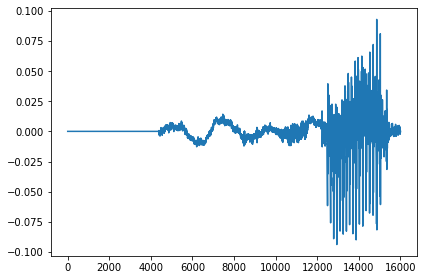

In [12]:
plt.plot(foo[0])

plt.tight_layout()
plt.show()

## **Modeling**

### **Preprocessing**

In [13]:
class Preprocessing(tf.keras.Model):
    
    def __init__(
        self, 
        frame_length = HPARAMS.frame_length, 
        frame_step   = HPARAMS.frame_step,
        fft_length   = HPARAMS.fft_length,
        window_fn    = HPARAMS.window_fn,
        pad_end      = HPARAMS.pad_end,
        num_mel_bins = HPARAMS.num_mel_bins, 
        num_spectrogram_bins = HPARAMS.num_spectrogram_bins, 
        sample_rate = HPARAMS.sample_rate, 
        lower_edge_hertz = HPARAMS.lower_edge_hertz,
        upper_edge_hertz = HPARAMS.upper_edge_hertz,
        **kwargs
    ):
        super(Preprocessing, self).__init__(self, **kwargs)
        
        ## STFT parameters.
        self.frame_length = frame_length
        self.frame_step   = frame_step
        self.fft_length   = fft_length
        self.window_fn    = window_fn
        self.pad_end      = pad_end
        
        ## Mel-spectrogram parameters.
        self.num_mel_bins = num_mel_bins
        self.num_spectrogram_bins = num_spectrogram_bins
        self.sample_rate = sample_rate
        self.lower_edge_hertz = lower_edge_hertz
        self.upper_edge_hertz = upper_edge_hertz
        
        ## Instance normalization layer.
        self.norm_layer = tfa.layers.InstanceNormalization()


    @tf.function        
    def _mel_spectrogram(self, x):
        stfts = tf.signal.stft(
            x, 
            frame_length = self.frame_length, 
            frame_step   = self.frame_step,
            fft_length   = self.fft_length,
            window_fn    = self.window_fn,
            pad_end      = self.pad_end,
        )

        spectrograms = tf.abs(stfts)

        mel_spectrograms = tf.tensordot(
            spectrograms, 
            tf.signal.linear_to_mel_weight_matrix(
                num_mel_bins = self.num_mel_bins, 
                num_spectrogram_bins = self.num_spectrogram_bins, 
                sample_rate = self.sample_rate, 
                lower_edge_hertz = self.lower_edge_hertz,
                upper_edge_hertz = self.upper_edge_hertz,
            ),
            1,
        )

        return mel_spectrograms
    
    @tf.function
    def _instance_normalization(self, x, training = None):
        return self.norm_layer(x, training = training)
    
    @tf.function
    def call(self, x, training = None):
        ## Only float32 & float64 allowed in mel-spectrogram operation.
        x = tf.cast(x, dtype = tf.float32)
        x = self._mel_spectrogram(x)
        x = tf.cast(x, dtype = tf.float16)

        x = self._instance_normalization(x, training = training)
        return x

### **Attentive Statistics Pooling**

In [14]:
## Ref: https://github.com/clovaai/voxceleb_trainer
class AttentiveStatisticsPooling(tf.keras.layers.Layer):
    
    def __init__(
        self, 
        reduction_dim = 128,
        activation_fn = tf.nn.relu6,
        **kwargs,
    ):
        super(AttentiveStatisticsPooling, self).__init__(**kwargs)
        
        self.reduction_dim = reduction_dim
        self.activation_fn = activation_fn
        self.epsilon       = tf.constant(1e-5, dtype = tf.float16) ## tf.float32
    
    def build(self, input_shape):
        ## ASP version 2, not textbook implementation.
        self.attention = tf.keras.Sequential([
            tf.keras.layers.Conv1D(self.reduction_dim, 1),
            tf.keras.layers.Activation(self.activation_fn),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv1D(input_shape[-1], 1),
            tf.keras.layers.Activation(tf.nn.softmax),
        ])
    
    @tf.function
    def call(self, x, training = None):
        """
             input shape: (None, frames, num_mel_bins)
            output shape: (None, 2 * num_mel_bins)
        """
        w = self.attention(x, training = training)
        
        mu = tf.math.reduce_sum(x * w, axis = -1)
        va = tf.math.reduce_sum(w * (x ** 2), axis = -1) - (mu ** 2)
        sg = tf.math.sqrt(tf.where(va < self.epsilon, self.epsilon, va)) ## either can apply relu
        
        return tf.concat([mu, sg], axis = -1)

### **Body**

In [15]:
def create_NN(
    model_name: str = None, 
    num_classes: int = HPARAMS.num_classes,
    pooling: str = "GAP",
) -> tf.keras.Model:
    x = model_input = tf.keras.layers.Input(shape = (HPARAMS.slice_length,))

    ## Entry flow: preprocessing.
    x = Preprocessing()(x)
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))(x)
    x = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]))(x)

    ## Middle flow: backbone.
    x = tf.keras.applications.resnet50.ResNet50(
        input_shape = x.shape[1:],
        weights = "imagenet",
        include_top = False,
    )(x)

    ## Exit flow: global pooling.
    assert pooling in ["GAP", "ASP"]
    if pooling == "GAP":
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    else:
        x = tf.keras.layers.Reshape((x.shape[1], -1))(x)
        x = tf.keras.layers.Permute((2, 1))(x)
        x = AttentiveStatisticsPooling()(x)

    x = tf.keras.layers.Dense(num_classes)(x)

    ## Exit flow: postprocessing for mixed precision training.
    model_output = x = tf.keras.layers.Activation("linear", dtype = tf.float32)(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [16]:
tmp = create_NN("tmp")
tmp.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
preprocessing (Preprocessing (None, 200, 64)           128       
_________________________________________________________________
lambda (Lambda)              (None, 200, 64, 1)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 64, 3)        0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
________________________________________________________________

In [17]:
del tmp

## **Fit**

### **Global Average Pooling**

In [18]:
model = create_NN("model", pooling = "GAP")
model.compile(
    optimizer = tfa.optimizers.RectifiedAdam(
        learning_rate = HPARAMS.learning_rate,
        warmup_proportion = 0,
    ),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["acc"],
)

In [19]:
hist1 = model.fit(
    ds, 
    epochs = HPARAMS.epochs, 
    verbose = 1,
)

Epoch 1/10
167/167 [==============================] - 122s 317ms/step - loss: 1.7929 - acc: 0.4448
Epoch 2/10
167/167 [==============================] - 45s 270ms/step - loss: 1.3583 - acc: 0.7296
Epoch 3/10
167/167 [==============================] - 45s 270ms/step - loss: 1.2395 - acc: 0.7596
Epoch 4/10
167/167 [==============================] - 45s 269ms/step - loss: 1.1765 - acc: 0.7909
Epoch 5/10
167/167 [==============================] - 45s 270ms/step - loss: 0.9251 - acc: 0.8133
Epoch 6/10
167/167 [==============================] - 45s 269ms/step - loss: 1.0142 - acc: 0.7711
Epoch 7/10
167/167 [==============================] - 45s 269ms/step - loss: 0.9602 - acc: 0.7598
Epoch 8/10
167/167 [==============================] - 45s 270ms/step - loss: 1.0925 - acc: 0.7134
Epoch 9/10
167/167 [==============================] - 45s 269ms/step - loss: 1.1021 - acc: 0.7207
Epoch 10/10
167/167 [==============================] - 45s 270ms/step - loss: 1.1324 - acc: 0.6906


### **Attentive Statistics Pooling**

In [20]:
model = create_NN("model", pooling = "ASP")
model.compile(
    optimizer = tfa.optimizers.RectifiedAdam(
        learning_rate = HPARAMS.learning_rate,
        warmup_proportion = 0,
    ),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["acc"],
)

In [21]:
hist2 = model.fit(
    ds, 
    epochs = HPARAMS.epochs, 
    verbose = 1,
)

Epoch 1/10
167/167 [==============================] - 94s 333ms/step - loss: 2.5845 - acc: 0.2842
Epoch 2/10
167/167 [==============================] - 56s 336ms/step - loss: 1.6806 - acc: 0.3683
Epoch 3/10
167/167 [==============================] - 56s 336ms/step - loss: 1.4071 - acc: 0.5956
Epoch 4/10
167/167 [==============================] - 56s 336ms/step - loss: 1.0599 - acc: 0.7253
Epoch 5/10
167/167 [==============================] - 56s 334ms/step - loss: 1.0678 - acc: 0.6998
Epoch 6/10
167/167 [==============================] - 56s 336ms/step - loss: 1.2089 - acc: 0.6414
Epoch 7/10
167/167 [==============================] - 56s 338ms/step - loss: 0.8880 - acc: 0.7614
Epoch 8/10
167/167 [==============================] - 56s 337ms/step - loss: 0.8396 - acc: 0.7935
Epoch 9/10
167/167 [==============================] - 56s 337ms/step - loss: 0.8822 - acc: 0.7629
Epoch 10/10
167/167 [==============================] - 56s 337ms/step - loss: 1.1159 - acc: 0.6913


### **Visualize**

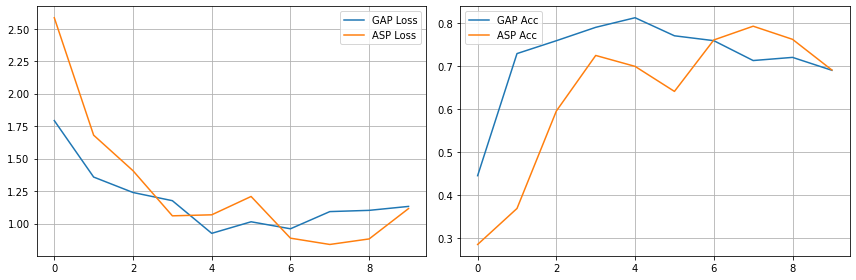

In [26]:
plt.figure(figsize = (12, 4), facecolor = "white")

plt.subplot(1, 2, 1)
plt.plot(hist1.history["loss"], label = "GAP Loss")
plt.plot(hist2.history["loss"], label = "ASP Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist1.history["acc"], label = "GAP Acc")
plt.plot(hist2.history["acc"], label = "ASP Acc")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()